<a href="https://colab.research.google.com/github/manmeet3591/python_class/blob/master/deep_learning/wrf_python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install condacolab
!conda install --yes -c conda-forge wrf-python
##!pip install -U numpy
import condacolab
condacolab.install()
condacolab.install_anaconda()
import numpy as np
import xarray as xr

!conda install --yes -c conda-forge cartopy
!pip install metpy
# Any import of metpy will activate the accessors
import metpy.calc as mpcalc
from metpy.cbook import get_test_data
from metpy.units import units
from google.colab import drive
drive.mount('/content/drive/')

Solving environment: / - \ | / - \ | / - \ | / - \ | / - \ | / done

# All requested packages already installed.

✨🍰✨ Everything looks OK!
✨🍰✨ Everything looks OK!
Solving environment: | / - \ | / - \ | / - \ | / - \ | / - \ | done

# All requested packages already installed.

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
from wrf import (to_np, getvar, smooth2d, get_cartopy, cartopy_xlim,
                 cartopy_ylim, latlon_coords)

In [ ]:
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import cartopy.crs as crs
from cartopy.feature import NaturalEarthFeature

from wrf import (to_np, getvar, smooth2d, get_cartopy, cartopy_xlim,
                 cartopy_ylim, latlon_coords)

In [ ]:
# Open the NetCDF file
import os
os.chdir("drive/My Drive/")
ncfile = Dataset("wrfout_d01_2016-10-07_00_00_00_subset.nc")


/usr/local/lib/python3.7/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/50m/physical/ne_50m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


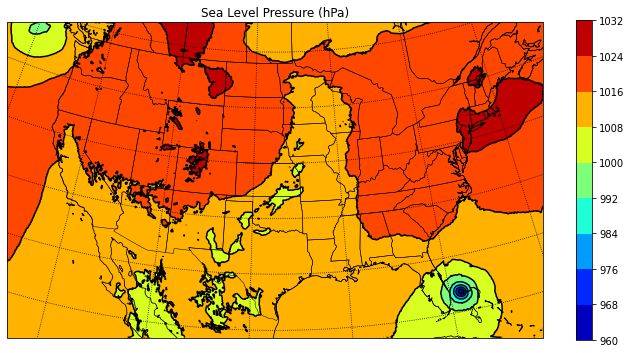

In [ ]:
# Get the sea level pressure
slp = getvar(ncfile, "slp")

# Smooth the sea level pressure since it tends to be noisy near the
# mountains
smooth_slp = smooth2d(slp, 3, cenweight=4)

# Get the latitude and longitude points
lats, lons = latlon_coords(slp)

# Get the cartopy mapping object
cart_proj = get_cartopy(slp)

# Create a figure
fig = plt.figure(figsize=(12,6))
# Set the GeoAxes to the projection used by WRF
ax = plt.axes(projection=cart_proj)

# Download and add the states and coastlines
states = NaturalEarthFeature(category="cultural", scale="50m",
                             facecolor="none",
                             name="admin_1_states_provinces_shp")
ax.add_feature(states, linewidth=.5, edgecolor="black")
ax.coastlines('50m', linewidth=0.8)

# Make the contour outlines and filled contours for the smoothed sea level
# pressure.
plt.contour(to_np(lons), to_np(lats), to_np(smooth_slp), 10, colors="black",
            transform=crs.PlateCarree())
plt.contourf(to_np(lons), to_np(lats), to_np(smooth_slp), 10,
             transform=crs.PlateCarree(),
             cmap=get_cmap("jet"))

# Add a color bar
plt.colorbar(ax=ax, shrink=.98)

# Set the map bounds
ax.set_xlim(cartopy_xlim(smooth_slp))
ax.set_ylim(cartopy_ylim(smooth_slp))

# Add the gridlines
ax.gridlines(color="black", linestyle="dotted")

plt.title("Sea Level Pressure (hPa)")

plt.show()

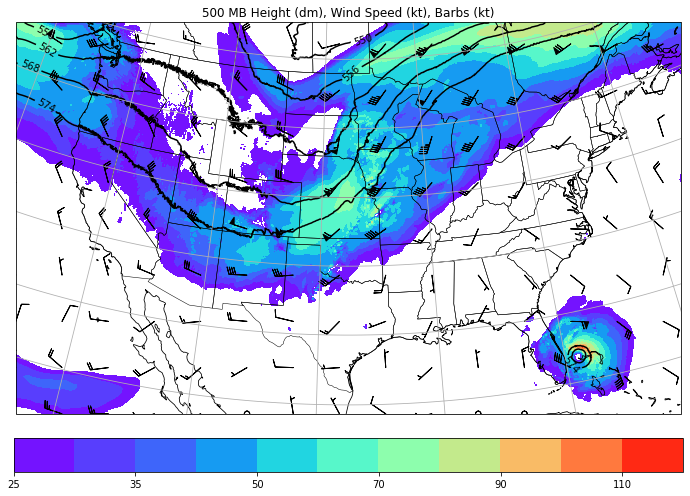

In [ ]:
from wrf import (getvar, interplevel, to_np, latlon_coords, get_cartopy,
                 cartopy_xlim, cartopy_ylim)

# Extract the pressure, geopotential height, and wind variables
p = getvar(ncfile, "pressure")
z = getvar(ncfile, "z", units="dm")
ua = getvar(ncfile, "ua", units="kt")
va = getvar(ncfile, "va", units="kt")
wspd = getvar(ncfile, "wspd_wdir", units="kts")[0,:]

# Interpolate geopotential height, u, and v winds to 500 hPa
ht_500 = interplevel(z, p, 500)
u_500 = interplevel(ua, p, 500)
v_500 = interplevel(va, p, 500)
wspd_500 = interplevel(wspd, p, 500)

# Get the lat/lon coordinates
lats, lons = latlon_coords(ht_500)

# Get the map projection information
cart_proj = get_cartopy(ht_500)

# Create the figure
fig = plt.figure(figsize=(12,9))
ax = plt.axes(projection=cart_proj)

# Download and add the states and coastlines
states = NaturalEarthFeature(category="cultural", scale="50m",
                             facecolor="none",
                             name="admin_1_states_provinces_shp")
ax.add_feature(states, linewidth=0.5, edgecolor="black")
ax.coastlines('50m', linewidth=0.8)

# Add the 500 hPa geopotential height contours
levels = np.arange(520., 580., 6.)
contours = plt.contour(to_np(lons), to_np(lats), to_np(ht_500),
                       levels=levels, colors="black",
                       transform=crs.PlateCarree())
plt.clabel(contours, inline=1, fontsize=10, fmt="%i")

# Add the wind speed contours
levels = [25, 30, 35, 40, 50, 60, 70, 80, 90, 100, 110, 120]
wspd_contours = plt.contourf(to_np(lons), to_np(lats), to_np(wspd_500),
                             levels=levels,
                             cmap=get_cmap("rainbow"),
                             transform=crs.PlateCarree())
plt.colorbar(wspd_contours, ax=ax, orientation="horizontal", pad=.05)

# Add the 500 hPa wind barbs, only plotting every 125th data point.
plt.barbs(to_np(lons[::125,::125]), to_np(lats[::125,::125]),
          to_np(u_500[::125, ::125]), to_np(v_500[::125, ::125]),
          transform=crs.PlateCarree(), length=6)

# Set the map bounds
ax.set_xlim(cartopy_xlim(ht_500))
ax.set_ylim(cartopy_ylim(ht_500))

ax.gridlines()

plt.title("500 MB Height (dm), Wind Speed (kt), Barbs (kt)")

plt.show()

In [ ]:
# from wrf import (getvar, to_np, vertcross, smooth2d, CoordPair, GeoBounds,
#                  get_cartopy, latlon_coords, cartopy_xlim, cartopy_ylim)

# # Get the WRF variables
# slp = getvar(ncfile, "slp")
# smooth_slp = smooth2d(slp, 3)
# ctt = getvar(ncfile, "ctt")
# z = getvar(ncfile, "z")
# dbz = getvar(ncfile, "dbz")
# Z = 10**(dbz/10.)
# wspd =  getvar(ncfile, "wspd_wdir", units="kt")[0,:]

# # Set the start point and end point for the cross section
# start_point = CoordPair(lat=26.76, lon=-80.0)
# end_point = CoordPair(lat=26.76, lon=-77.8)

# # Compute the vertical cross-section interpolation.  Also, include the
# # lat/lon points along the cross-section in the metadata by setting latlon
# # to True.
# z_cross = vertcross(Z, z, wrfin=ncfile, start_point=start_point,
#                     end_point=end_point, latlon=True, meta=True)
# wspd_cross = vertcross(wspd, z, wrfin=ncfile, start_point=start_point,
#                        end_point=end_point, latlon=True, meta=True)
# dbz_cross = 10.0 * np.log10(z_cross)

# # Get the lat/lon points
# lats, lons = latlon_coords(slp)

# # Get the cartopy projection object
# cart_proj = get_cartopy(slp)

# # Create a figure that will have 3 subplots
# fig = plt.figure(figsize=(12,9))
# ax_ctt = fig.add_subplot(1,2,1,projection=cart_proj)
# ax_wspd = fig.add_subplot(2,2,2)
# ax_dbz = fig.add_subplot(2,2,4)

# # Download and create the states, land, and oceans using cartopy features
# states = cfeature.NaturalEarthFeature(category='cultural', scale='50m',
#                                       facecolor='none',
#                                       name='admin_1_states_provinces_shp')
# land = cfeature.NaturalEarthFeature(category='physical', name='land',
#                                     scale='50m',
#                                     facecolor=cfeature.COLORS['land'])
# ocean = cfeature.NaturalEarthFeature(category='physical', name='ocean',
#                                      scale='50m',
#                                      facecolor=cfeature.COLORS['water'])

# # Make the pressure contours
# contour_levels = [960, 965, 970, 975, 980, 990]
# c1 = ax_ctt.contour(lons, lats, to_np(smooth_slp), levels=contour_levels,
#                     colors="white", transform=crs.PlateCarree(), zorder=3,
#                     linewidths=1.0)

# # Create the filled cloud top temperature contours
# contour_levels = [-80.0, -70.0, -60, -50, -40, -30, -20, -10, 0, 10]
# ctt_contours = ax_ctt.contourf(to_np(lons), to_np(lats), to_np(ctt),
#                                contour_levels, cmap=get_cmap("Greys"),
#                                transform=crs.PlateCarree(), zorder=2)

# ax_ctt.plot([start_point.lon, end_point.lon],
#             [start_point.lat, end_point.lat], color="yellow", marker="o",
#             transform=crs.PlateCarree(), zorder=3)

# # Create the color bar for cloud top temperature
# cb_ctt = fig.colorbar(ctt_contours, ax=ax_ctt, shrink=.60)
# cb_ctt.ax.tick_params(labelsize=5)

# # Draw the oceans, land, and states
# ax_ctt.add_feature(ocean)
# ax_ctt.add_feature(land)
# ax_ctt.add_feature(states, linewidth=.5, edgecolor="black")

# # Crop the domain to the region around the hurricane
# hur_bounds = GeoBounds(CoordPair(lat=np.amin(to_np(lats)), lon=-85.0),
#                        CoordPair(lat=30.0, lon=-72.0))
# ax_ctt.set_xlim(cartopy_xlim(ctt, geobounds=hur_bounds))
# ax_ctt.set_ylim(cartopy_ylim(ctt, geobounds=hur_bounds))
# ax_ctt.gridlines(color="white", linestyle="dotted")

# # Make the contour plot for wind speed
# wspd_contours = ax_wspd.contourf(to_np(wspd_cross), cmap=get_cmap("jet"))
# # Add the color bar
# cb_wspd = fig.colorbar(wspd_contours, ax=ax_wspd)
# cb_wspd.ax.tick_params(labelsize=5)

# # Make the contour plot for dbz
# levels = [5 + 5*n for n in range(15)]
# dbz_contours = ax_dbz.contourf(to_np(dbz_cross), levels=levels,
#                                cmap=get_cmap("jet"))
# cb_dbz = fig.colorbar(dbz_contours, ax=ax_dbz)
# cb_dbz.ax.tick_params(labelsize=5)

# # Set the x-ticks to use latitude and longitude labels
# coord_pairs = to_np(dbz_cross.coords["xy_loc"])
# x_ticks = np.arange(coord_pairs.shape[0])
# x_labels = [pair.latlon_str() for pair in to_np(coord_pairs)]
# ax_wspd.set_xticks(x_ticks[::20])
# ax_wspd.set_xticklabels([], rotation=45)
# ax_dbz.set_xticks(x_ticks[::20])
# ax_dbz.set_xticklabels(x_labels[::20], rotation=45, fontsize=4)

# # Set the y-ticks to be height
# vert_vals = to_np(dbz_cross.coords["vertical"])
# v_ticks = np.arange(vert_vals.shape[0])
# ax_wspd.set_yticks(v_ticks[::20])
# ax_wspd.set_yticklabels(vert_vals[::20], fontsize=4)
# ax_dbz.set_yticks(v_ticks[::20])
# ax_dbz.set_yticklabels(vert_vals[::20], fontsize=4)

# # Set the x-axis and  y-axis labels
# ax_dbz.set_xlabel("Latitude, Longitude", fontsize=5)
# ax_wspd.set_ylabel("Height (m)", fontsize=5)
# ax_dbz.set_ylabel("Height (m)", fontsize=5)

# # Add a title
# ax_ctt.set_title("Cloud Top Temperature (degC)", {"fontsize" : 7})
# ax_wspd.set_title("Cross-Section of Wind Speed (kt)", {"fontsize" : 7})
# ax_dbz.set_title("Cross-Section of Reflectivity (dBZ)", {"fontsize" : 7})

# plt.show()

In [ ]:
from wrf import (getvar, to_np, vertcross, smooth2d, CoordPair,
                 get_basemap, latlon_coords)


# Get the WRF variables
slp = getvar(ncfile, "slp")
smooth_slp = smooth2d(slp, 3)
ctt = getvar(ncfile, "ctt")
z = getvar(ncfile, "z")
dbz = getvar(ncfile, "dbz")
Z = 10**(dbz/10.)
wspd =  getvar(ncfile, "wspd_wdir", units="kt")[0,:]

# Set the start point and end point for the cross section
start_point = CoordPair(lat=26.76, lon=-80.0)
end_point = CoordPair(lat=26.76, lon=-77.8)

# Compute the vertical cross-section interpolation.  Also, include the
# lat/lon points along the cross-section in the metadata by setting latlon
# to True.
z_cross = vertcross(Z, z, wrfin=ncfile, start_point=start_point,
                    end_point=end_point, latlon=True, meta=True)
wspd_cross = vertcross(wspd, z, wrfin=ncfile, start_point=start_point,
                       end_point=end_point, latlon=True, meta=True)
dbz_cross = 10.0 * np.log10(z_cross)

# Get the latitude and longitude points
lats, lons = latlon_coords(slp)

# Create the figure that will have 3 subplots
fig = plt.figure(figsize=(12,9))
ax_ctt = fig.add_subplot(1,2,1)
ax_wspd = fig.add_subplot(2,2,2)
ax_dbz = fig.add_subplot(2,2,4)

# Get the basemap object
bm = get_basemap(slp)

# Convert the lat/lon points in to x/y points in the projection space
x, y = bm(to_np(lons), to_np(lats))

# Make the pressure contours
contour_levels = [960, 965, 970, 975, 980, 990]
c1 = bm.contour(x, y, to_np(smooth_slp), levels=contour_levels,
                colors="white", zorder=3, linewidths=1.0, ax=ax_ctt)

# Create the filled cloud top temperature contours
contour_levels = [-80.0, -70.0, -60, -50, -40, -30, -20, -10, 0, 10]
ctt_contours = bm.contourf(x, y, to_np(ctt), contour_levels,
                           cmap=get_cmap("Greys"), zorder=2, ax=ax_ctt)

point_x, point_y = bm([start_point.lon, end_point.lon],
                      [start_point.lat, end_point.lat])
bm.plot([point_x[0], point_x[1]], [point_y[0], point_y[1]], color="yellow",
        marker="o", zorder=3, ax=ax_ctt)

# Create the color bar for cloud top temperature
cb_ctt = fig.colorbar(ctt_contours, ax=ax_ctt, shrink=.60)
cb_ctt.ax.tick_params(labelsize=5)

# Draw the oceans, land, and states
bm.drawcoastlines(linewidth=0.25, ax=ax_ctt)
bm.drawstates(linewidth=0.25, ax=ax_ctt)
bm.drawcountries(linewidth=0.25, ax=ax_ctt)
bm.fillcontinents(color=np.array([ 0.9375 , 0.9375 , 0.859375]),
                                 ax=ax_ctt,
                                 lake_color=np.array([0.59375 ,
                                                      0.71484375,
                                                      0.8828125 ]))
bm.drawmapboundary(fill_color=np.array([ 0.59375 , 0.71484375, 0.8828125 ]),
                   ax=ax_ctt)

# Draw Parallels
parallels = np.arange(np.amin(lats), 30., 2.5)
bm.drawparallels(parallels, ax=ax_ctt, color="white")

merids = np.arange(-85.0, -72.0, 2.5)
bm.drawmeridians(merids, ax=ax_ctt, color="white")

# Crop the image to the hurricane region
x_start, y_start = bm(-85.0, np.amin(lats))
x_end, y_end = bm(-72.0, 30.0)

ax_ctt.set_xlim([x_start, x_end])
ax_ctt.set_ylim([y_start, y_end])

# Make the contour plot for wspd
wspd_contours = ax_wspd.contourf(to_np(wspd_cross), cmap=get_cmap("jet"))
# Add the color bar
cb_wspd = fig.colorbar(wspd_contours, ax=ax_wspd)
cb_wspd.ax.tick_params(labelsize=5)

# Make the contour plot for dbz
levels = [5 + 5*n for n in range(15)]
dbz_contours = ax_dbz.contourf(to_np(dbz_cross), levels=levels,
                               cmap=get_cmap("jet"))
cb_dbz = fig.colorbar(dbz_contours, ax=ax_dbz)
cb_dbz.ax.tick_params(labelsize=5)

# Set the x-ticks to use latitude and longitude labels.
coord_pairs = to_np(dbz_cross.coords["xy_loc"])
x_ticks = np.arange(coord_pairs.shape[0])
x_labels = [pair.latlon_str() for pair in to_np(coord_pairs)]
ax_wspd.set_xticks(x_ticks[::20])
ax_wspd.set_xticklabels([], rotation=45)
ax_dbz.set_xticks(x_ticks[::20])
ax_dbz.set_xticklabels(x_labels[::20], rotation=45, fontsize=4)

# Set the y-ticks to be height.
vert_vals = to_np(dbz_cross.coords["vertical"])
v_ticks = np.arange(vert_vals.shape[0])
ax_wspd.set_yticks(v_ticks[::20])
ax_wspd.set_yticklabels(vert_vals[::20], fontsize=4)
ax_dbz.set_yticks(v_ticks[::20])
ax_dbz.set_yticklabels(vert_vals[::20], fontsize=4)

# Set the x-axis and  y-axis labels
ax_dbz.set_xlabel("Latitude, Longitude", fontsize=5)
ax_wspd.set_ylabel("Height (m)", fontsize=5)
ax_dbz.set_ylabel("Height (m)", fontsize=5)

# Add titles
ax_ctt.set_title("Cloud Top Temperature (degC)", {"fontsize" : 7})
ax_wspd.set_title("Cross-Section of Wind Speed (kt)", {"fontsize" : 7})
ax_dbz.set_title("Cross-Section of Reflectivity (dBZ)", {"fontsize" : 7})

plt.show()